<!--NAVIGATION-->
<a href="https://colab.research.google.com/github/marcoteran/machinelearning/blob/master/notebooks/01_machinelearning/s4_artificialintelligence_svm_modelselection.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"></a>

### Ejemplo de código
# Sesión 04: Máquinas de vectores de soporte y selección de modelos
## Inteligencia Artificial

**Name:** Marco Teran **E-mail:** marco.tulio.teran@gmail.com,
[Website](http://marcoteran.github.io/),
[Github](https://github.com/marcoteran),
[LinkedIn](https://www.linkedin.com/in/marcoteran/).
___

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.model_selection import train_test_split
from matplotlib.colors import Normalize

In [2]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color.reshape(1,-1),
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def plot_labels(n_folds, n_classes, list_labels):
    ind = np.arange(n_folds)
    width = 0.15
    
    countings = []
    for labels in list_labels:
        labels = np.array(labels)
        countings.append([np.count_nonzero(labels == x) for x in range(n_classes)])
    
    class_bars = []
    for cls in range(n_classes):
        class_bars.append([l[cls] for l in countings])
    
    fig, ax = pl.subplots()
    i = 0
    for class_bar in class_bars:
        ax.bar(ind + width*i, class_bar, width, label='Clase '+str(i))
        i += 1
        
    ax.set_xticks(ind + 2*width / 3)
    ax.set_xticklabels(['Pliegue {}'.format(k) for k in range(n_folds)])
    pl.legend(loc="best")
    pl.title("Etiquetas")

# Máquinas de vectores de soporte
**Support Vector Machines**

Las máquinas de vectores de soporte (SVM)  son un conjunto de modelos de aprendizaje supervisado que se utilizan para la clasificación, la regresión y la detección de valores atípicos, en el cual los ejemplos son representados en un nuevo espacio, de tal forma que aquellos ejemplos de diferentes categorías sea posible, en principio, separarlos linealmente.

Las ventajas de las máquinas de vectores soporte son:
* Son eficaces en espacios de alta dimensión.
* Siguen siendo eficaces en los casos en que el número de dimensiones es mayor que el número de muestras.
* Utiliza un subconjunto de puntos de entrenamiento en la función de decisión (llamados vectores de soporte), por lo que también es eficiente en cuanto a memoria.
* **Versátil:** se pueden especificar diferentes funciones del Kernel para la función de decisión. Se proporcionan kernels comunes, pero también es posible especificar kernels personalizados.

Las desventajas de las máquinas de vectores de soporte son:
* Si el número de características es mucho mayor que el número de muestras, es crucial evitar el sobreajuste en la elección de las funciones Kernel y el término de regularización.
* Las SVM no proporcionan directamente estimaciones de probabilidad, éstas se calculan mediante una costosa validación cruzada de cinco pliegues.

## Definición del conjunto de datos

Vamos a trabajar con un conjunto de datos artificial (conjunto de datos de juguete). El conjunto es creado usando la funcionalidad `make_circles` de Scikit-Learn [ver más](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html).

`make_circles` permite crear un círculo grande que contenga un círculo más pequeño en 2d.
Un simple conjunto de datos de juguete para visualizar los algoritmos de agrupación y xclasificación.

Considere el siguiente ejemplo de un conjunto de datos:

In [3]:
# Cargue las funciones datos make_circles n_samples=1000, factor=.3 (separación entre circulos), noise=.05
from sklearn.datasets import make_circles

In [4]:
np.random.seed(0)
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.05)

Se trata de un conjunto de datos que no es linealmente separable

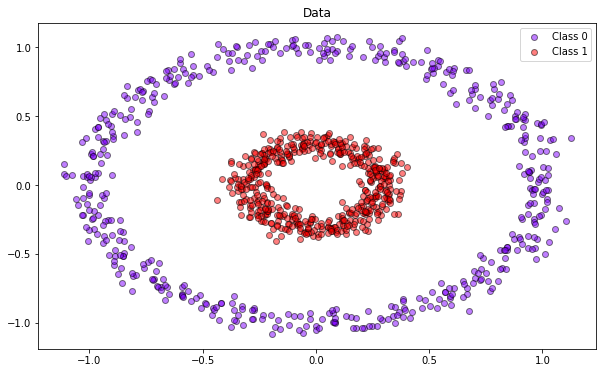

In [5]:
# Dibuje los datos
pl.figure(figsize=(10,6))
plot_data(X, y)

## ¿Cómo separar los datos?

SVM  crea, implícitamente, un espacio de representación de mayor dimensionalidad en el cual podemos separar de forma clara nuestros datos. Por ejemplo:

<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/kernel_trick.png" width="60%">

## Kernel trick

SVM usa una función conocida como kernel. Intuitivamente, esta función $k$ define qué tan parecidas son dos instancias del conjunto de datos. Formalmente, la función $k$ calcula el producto punto en el espacio de caracterísiticas donde se representarán los datos. Dependiendo del kernel, este espacio de característica es de mayor dimensionalidad, y facilita la  definición de un "*hiperplano*" que separe los ejemplos de ambas características. 

Existen varias opciones para las funciones de kernel. Primero vamos a cargar dos conjuntos de datos sobre los cuales vamos a comparar la superficie de decisión generada por cada tipo de kernel.

<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/differentkernels.png" width="60%">

In [6]:
# Cargar el conjunto de datos de iris (clases: versicolor y virginica)
from sklearn.datasets import load_iris

In [7]:
iris=load_iris()

In [8]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [9]:
X=iris.data[:,[1,2]]

In [10]:
y=iris.target

In [11]:
# Dividir el conjunto en 70% para entrenamiento y 30% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [12]:
# Cargar el conjunto de datos de moon: 600 muestras y noise 0.3
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=600, noise=0.3, random_state=0)

In [13]:
# Dividir el conjunto en 70% para entrenamiento y 30% para prueba
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons, test_size=0.3, random_state=1)

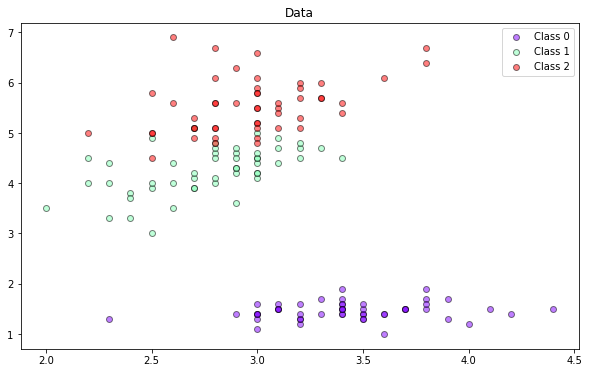

In [14]:
# Dibujar iris
# Dibuje los datos
pl.figure(figsize=(10,6))
plot_data(X, y)

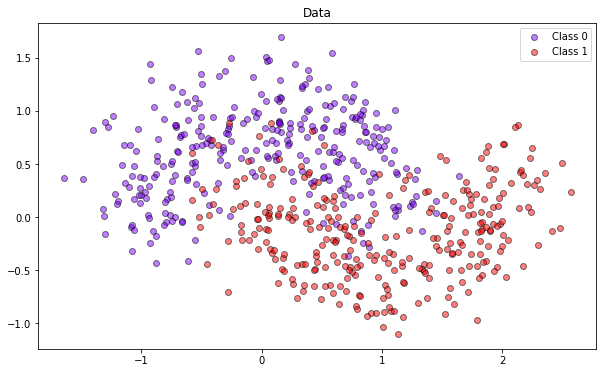

In [15]:
# Dibujar moon
# Dibuje los datos
pl.figure(figsize=(10,6))
plot_data(X_moons, y_moons)

## Kernel Lineal

La función $k$ está definida como:
$$
k(x,y) = \langle x, x\rangle = xx'
$$

Esta implementación puede ser consultada a través de `sklearn.svm.LinearSVC` [(ver más)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

In [16]:
# Importamos el metodo
from sklearn.svm import LinearSVC

In [17]:
# Crear dos clasificadores de kernel lineal: linear_iris y linear_moons
linear_iris=LinearSVC()
linear_moons=LinearSVC()

In [18]:
# Entrenamos los modelo `LinearSVC` llamando la función `fit()` sobre el conjunto de datos reducido
linear_iris.fit(X_train, y_train)
linear_moons.fit(X_moons_train, y_moons_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Ahora visualizamos los datos de ambos y la superficie de decisión:

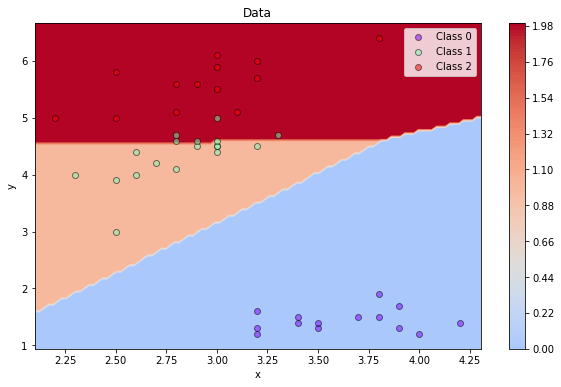

In [19]:
pl.figure(figsize=(10,6))
plot_decision_region(X_test, gen_pred_fun(linear_iris))
plot_data(X_test, y_test)

El error en el conjunto de entrenamiento y prueba es el siguiente:

In [20]:
# Error en entrenamiento para iris
# Error en prueba para iris
print('Error en entrenamiento para iris: {}'.format(1-linear_iris.score(X_train, y_train)))
print('Error en prueba para iris: {}'.format(1-linear_iris.score(X_test, y_test)))

Error en entrenamiento para iris: 0.08571428571428574
Error en prueba para iris: 0.1333333333333333


Ahora hacemos los mismo para el conjunto de datos generado artificialmente:

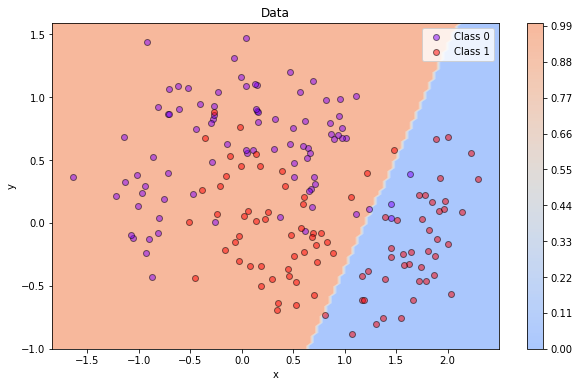

In [21]:
pl.figure(figsize=(10,6))
plot_decision_region(X_moons_test, gen_pred_fun(linear_iris))
plot_data(X_moons_test, y_moons_test)

In [22]:
# Error en entrenamiento para moons
# Error en prueba para moons
print('Error en entrenamiento para moons: {}'.format(1-linear_iris.score(X_moons_train, y_moons_train)))
print('Error en prueba para moons: {}'.format(1-linear_iris.score(X_moons_test, y_moons_test)))

Error en entrenamiento para moons: 0.7619047619047619
Error en prueba para moons: 0.7


## Kernel polinomial

La función $k$ está definida como:
$$
k(x,y) = (\gamma \langle x, x'\rangle + r)^d
$$
dónde $d$ corresponde al grado del polinomio (parametro `degree`) y $r$ por `coef0`. De manera similar podemos acceder a la implementación de este kernel a través de `sklearn.svm.SVC` [(ver más)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

Definimos primero un kernel polinomial de grado $2$.

In [23]:
# Importamos el metodo
from sklearn.svm import SVC

In [24]:
# Definimos el clasificador con kernel='poly' y degree=2
poly_svm=SVC(kernel='poly',degree=2)

In [25]:
poly_svm

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
# Entrenamos los modelo `SVC` llamando la función `fit()` sobre el conjunto de datos reducido
poly_svm.fit(X_moons_train, y_moons_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Ahora visualizamos los datos de ambos y la superficie de decisión:

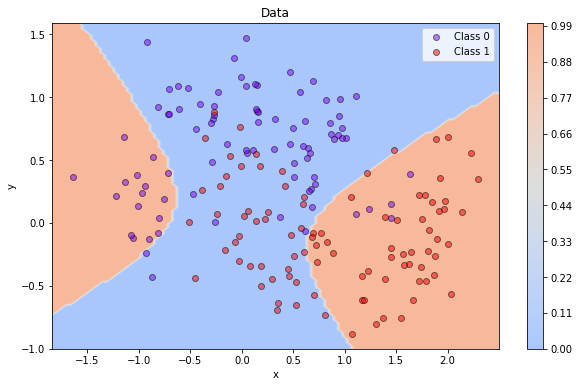

In [27]:
pl.figure(figsize=(10,6))
plot_decision_region(X_moons_test, gen_pred_fun(poly_svm))
plot_data(X_moons_test, y_moons_test)

In [28]:
# Error en entrenamiento para moons
# Error en prueba para moons
print('Error en entrenamiento para moons: {}'.format(1-poly_svm.score(X_moons_train, y_moons_train)))
print('Error en prueba para moons: {}'.format(1-poly_svm.score(X_moons_test, y_moons_test)))

Error en entrenamiento para moons: 0.3476190476190476
Error en prueba para moons: 0.3555555555555555


Ahora lo intentamos con un polinomio de grado $3$:

In [29]:
poly_svm_d3=SVC(kernel='poly',degree=3)
poly_svm_d3.fit(X_moons_train, y_moons_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Medimos el error en entrenamiento y prueba

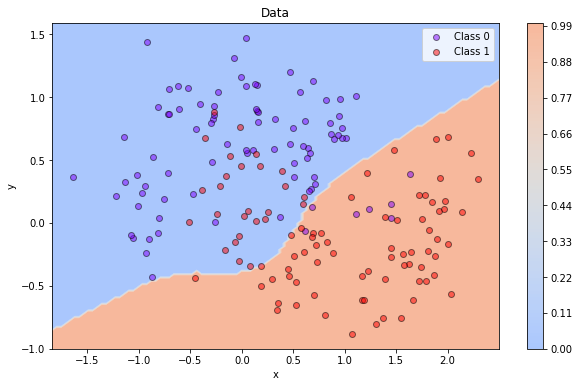

In [30]:
pl.figure(figsize=(10,6))
plot_decision_region(X_moons_test, gen_pred_fun(poly_svm_d3))
plot_data(X_moons_test, y_moons_test)

In [31]:
print("Error en entrenamiento: {}".format(1-poly_svm_d3.score(X_moons_train, y_moons_train)))
print("Error en prueba: {}".format(1-poly_svm_d3.score(X_moons_test, y_moons_test)))

Error en entrenamiento: 0.17619047619047623
Error en prueba: 0.18888888888888888


Ahora probamos con el conjunto de datos IRIS $(d=4)$:

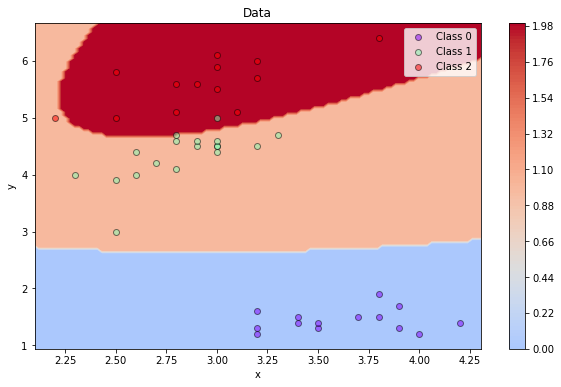

In [32]:
poly_svm = SVC(kernel='poly', degree=4)
poly_svm.fit(X_train, y_train)

pl.figure(figsize = (10, 6))    
plot_decision_region(X_test, gen_pred_fun(poly_svm))
plot_data(X_test, y_test)

In [33]:
# Error en entrenamiento
# Error en prueba
print("Error en entrenamiento: {}".format(1-poly_svm.score(X_train, y_train)))
print("Error en prueba: {}".format(1-poly_svm.score(X_test, y_test)))

Error en entrenamiento: 0.05714285714285716
Error en prueba: 0.0444444444444444


## Kernel Gaussiano


$$
K(x, x') = \exp\left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)
$$
la cual se puede simplificar como
$$
K(x, x') = \exp(-\gamma \|x-x'\|^2)
$$

donde $\gamma$ se especifica mediante el parámetro `gamma`, que debe ser mayor que $0$.

En la literatura este método tambien se encuentra como kernel usando una función de base radial (**RBF** por sus siglas en ingles).

Al entrenar una SVM con el kernel de la función de base radial (RBF), hay que tener en cuenta dos parámetros: $C$ y $\gamma$.
* El parámetro $C$, común a todos los kernels de SVM, es el **parametro de regularización**, que compensa la clasificación errónea de las muestras de entrenamiento en la complejidad de la superficie de decisión.
    - Un $C$ bajo hace que la superficie de decisión sea suave, mientras que un $C$ alto tiene como objetivo clasificar correctamente todos los ejemplos de entrenamiento.

<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/lowc.png" width="40%">
<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/highc.png" width="40%">

* $\gamma$ define cuánta influencia tiene una sola muestra de entrenamiento.
    - Cuanto mayor sea $\gamma$, más cerca deben estar las demás muestras para verse afectadas.

<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/highgamma.png" width="40%">
<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/lowgamma.png" width="40%">

La elección adecuada de $C$ y $\gamma$ es fundamental para el rendimiento de la SVM. Se aconseja utilizar `GridSearchCV` con $C$ y $\gamma$ espaciados exponencialmente para elegir buenos valores.

En el siguiente ejemplo probamos con un valor de $\gamma$ pequeño $(0.007)$:

In [34]:
# Cargamos el clasificador
rbf_svm = SVC(kernel='rbf', gamma=0.007)

In [35]:
rbf_svm

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.007, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

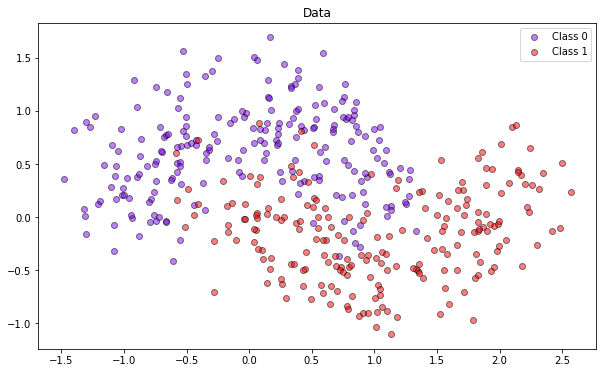

In [36]:
pl.figure(figsize = (10,6))
plot_data(X_moons_train, y_moons_train)

In [37]:
# Entrenamos el clasificador
rbf_svm.fit(X_moons_train, y_moons_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.007, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Ahora visualizamos los datos de ambos y la superficie de decisión:

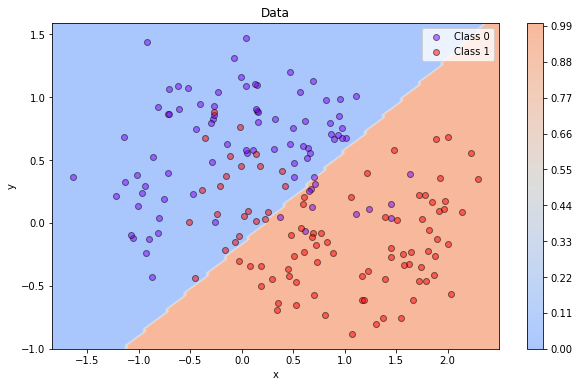

In [38]:
pl.figure(figsize=(10,6))
plot_decision_region(X_moons_test, gen_pred_fun(rbf_svm))
plot_data(X_moons_test, y_moons_test)

Reportamos el error de entrenamiento y prueba:

In [39]:
# Error en entrenamiento
# Error en prueba
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_moons_train, y_moons_train)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_moons_test, y_moons_test)))

Error en entrenamiento: 0.16190476190476188
Error en prueba: 0.18888888888888888


Usamos un $\gamma$ más grande $(10000)$

In [40]:
rbf_svm = SVC(kernel='rbf', gamma=10000)
rbf_svm.fit(X_moons_train, y_moons_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10000, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

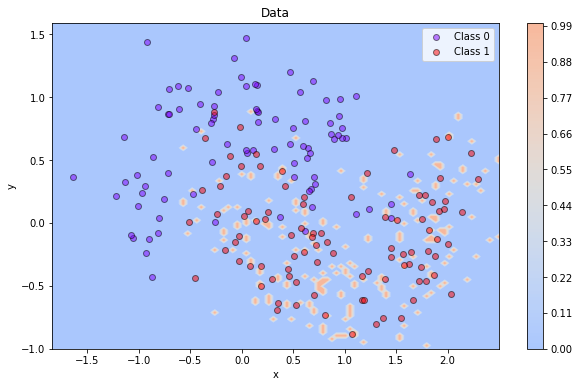

In [41]:
pl.figure(figsize=(10,6))
plot_decision_region(X_moons_test, gen_pred_fun(rbf_svm))
plot_data(X_moons_test, y_moons_test)

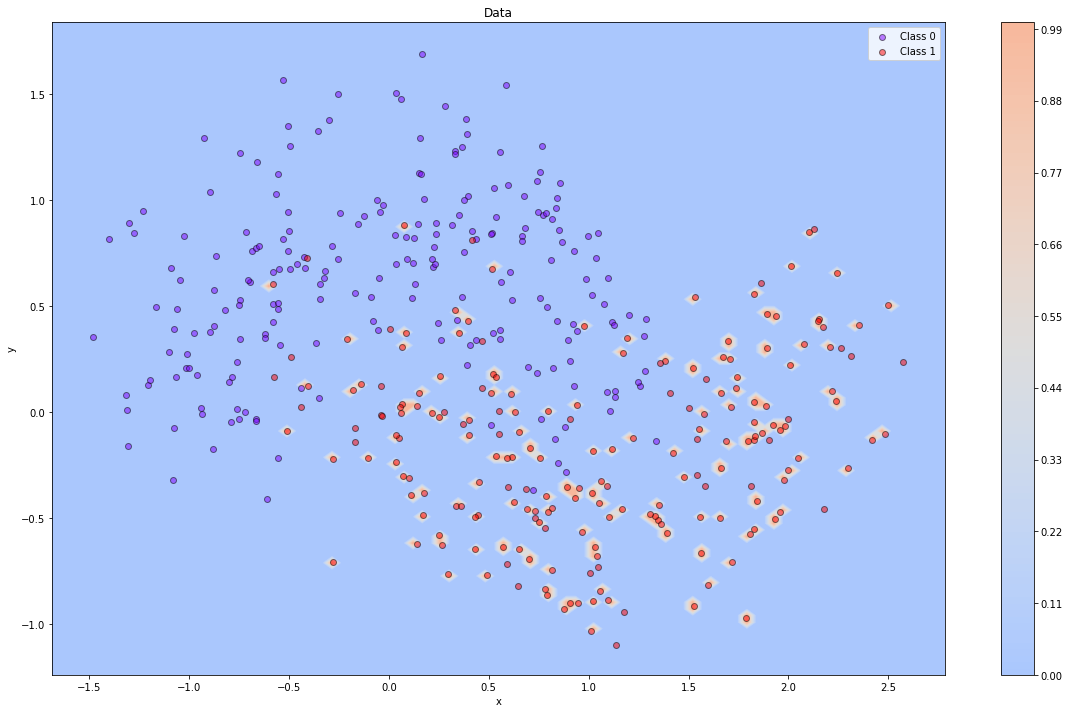

In [42]:
pl.figure(figsize=(20,12))
plot_decision_region(X_moons_train, gen_pred_fun(rbf_svm))
plot_data(X_moons_train, y_moons_train)

Ahora reportamos el error de entrenamiento y prueba:

In [43]:
# Error en entrenamiento
# Error en prueba
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_moons_train, y_moons_train)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_moons_test, y_moons_test)))

Error en entrenamiento: 0.0
Error en prueba: 0.4722222222222222


Ahora escogemos un valor de $\gamma$ intermedio $(0.7)$:

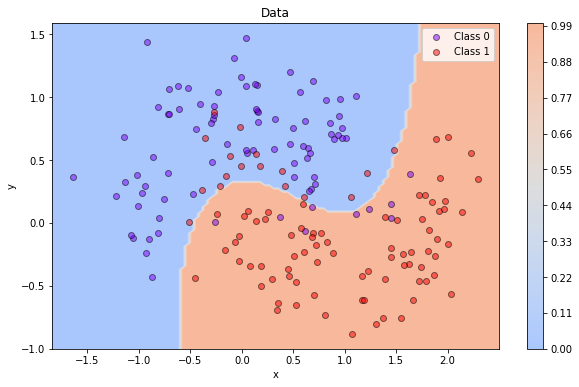

In [44]:
rbf_svm = SVC(kernel='rbf', gamma=0.7)
rbf_svm.fit(X_moons_train, y_moons_train)

pl.figure(figsize=(10,6))
plot_decision_region(X_moons_test, gen_pred_fun(rbf_svm))
plot_data(X_moons_test, y_moons_test)

In [45]:
# Error en entrenamiento
# Error en prueba
print("Error en entrenamiento: {}".format(1-rbf_svm.score(X_moons_train, y_moons_train)))
print("Error en prueba: {}".format(1-rbf_svm.score(X_moons_test, y_moons_test)))

Error en entrenamiento: 0.08809523809523812
Error en prueba: 0.1444444444444445


Probamos sobre el conjunto de datos IRIS $(\gamma=0.7)$

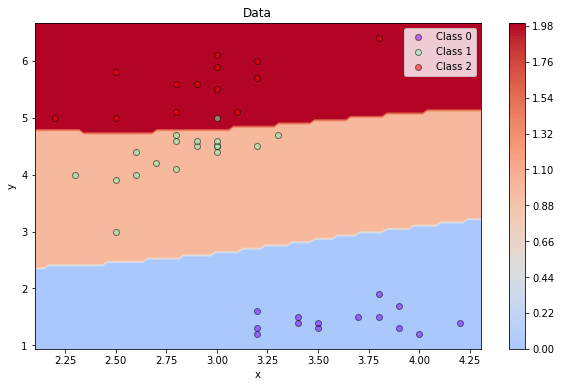

In [46]:
rbf_svm = SVC(kernel='rbf', gamma=0.7)
rbf_svm.fit(X_train, y_train)

pl.figure(figsize=(10,6))
plot_decision_region(X_test, gen_pred_fun(rbf_svm))
plot_data(X_test, y_test)

Finalmente reportamos el error en entrenamiento y prueba:

In [47]:
# Error en entrenamiento
# Error en prueba
print('Error en entrenamiento para iris: {}'.format(1-rbf_svm.score(X_train, y_train)))
print('Error en prueba para iris: {}'.format(1-rbf_svm.score(X_test, y_test)))

Error en entrenamiento para iris: 0.05714285714285716
Error en prueba para iris: 0.022222222222222254


# Estimando de una forma más robusta los hiperparámetros del modelo

Hasta el momento nos hemos concentrado en evaluar nuestros modelos en una partición de prueba. Sin embargo, es común introducir sobreajuste a través de la modificación manual de los hiperparámetros de un modelo conforme vamos reportando el error de generalización sobre el conjunto de prueba.

<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/train_val.svg" width="70%">

En la anterior imagen, introducimos una nueva partición, conocida como partición de "**validación**". Esta partición es resultado de tomar la partición de entrenamiento y volver a dividirla (en entrenamiento y validación) de tal forma que cualquier configuración de parámetros que se use para entrenar un modelo, pueda ser reportada en **validación**. Una vez estemos seguros que tenemos el modelo con el mejor desempeño en **validación**, volvemos a unir ambas particiones, entrenamos un modelo sobre la partición original de entrenamiento y reportamos **una sola vez** en el conjunto de prueba.

# Validación cruzada de  k pliegues

A pesar de que se introdujo una nueva partición para validar los parámetros de un modelo, se sigue usando una partición reducida para entrenar el conjunto de datos. La validación cruzada nos permite usar una mayor parte de los datos para construír el modelo y generar un estimador más robusto y con mayor capacidad de generalización. En validación cruzada, los datos son particionados varias veces en entrenamiento y validación de forma repetida. Finalmente el desempeño del clasificador es agregado sobre las diferentes particiones de validación para obtener un estimador más robusto.

La validación cruzada se hace comúnmente de la siguiente manera:
* Se divide el conjunto de entrenamiento en k-pliegues o particiones (usualmente 3, 5 o 10).
* Estas particiones deben ser del mismo tamaño
* En cada iteración uno de los pliegues es usado como la partición de validación, mientras el resto es usado como la partición de entrenamiento.
* Se reporta y guarda el desempeño sobre esa partición de validación

<img src="https://github.com/marcoteran/artificialintelligence/raw/master/notebooks/01_machinelearnig/figures/cv2.svg" width="70%">

Vamos a usar el conjunto de datos IRIS y construímos cada uno de los pliegues:

In [48]:
# Cargamos los datos iris
X=iris.data
y=iris.target

In [49]:
# Creamos el clasificador LinearSVC
linSVC =LinearSVC()

In [50]:
# Número de pliegues k=5 (mostrar tamaño de cada pliegue)
k=5
n_samples=len(X)
fold_size=n_samples/k

print("Número de muestras por pliegue: {}".format(fold_size))


Número de muestras por pliegue: 30.0


Primero hacemos un reordenamiento aleatorio de los datos utilizando la función `shuffle`. De tal forma que las clases estén distribuídas a lo largo de los $k$-pliegues.

In [51]:
from sklearn.utils import shuffle
X,y=shuffle(X,y,random_state=0)

Para cada pliegue vamos a construir una máscara sobre los datos, que indicará mi partición de entrenamiento y de validación.

In [52]:
# Mostrar la distribución de equiquetas por pliegue
scores = []
masks = []


for fold in range(k):
    val_mask = np.zeros(n_samples, dtype=bool)
    val_mask[int(fold * fold_size) : int((fold + 1) * fold_size)] = True
    masks.append(val_mask)
    X_val, y_val = X[val_mask], y[val_mask]
    print('Distribución de etiquetas en el pliegue {}: {}'
          .format(fold, np.bincount(y_val)))
    
    X_train, y_train = X[~val_mask], y[~val_mask]
    linSVC.fit(X_train, y_train)
    scores.append(linSVC.score(X_val, y_val))

Distribución de etiquetas en el pliegue 0: [11 13  6]
Distribución de etiquetas en el pliegue 1: [ 5 10 15]
Distribución de etiquetas en el pliegue 2: [10 10 10]
Distribución de etiquetas en el pliegue 3: [14  6 10]
Distribución de etiquetas en el pliegue 4: [10 11  9]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

A continuación tenemos el accuracy para cada pliegue de **validación** y su respectivo promedio:

In [53]:
# Mostramos la accuracy por cada pliegue
# Mostramos promedio sobre los 5 pliegues
print("Accuracy por cada pliegue: {}".format(scores))
print("Promedio sobre los 5 pliegues: {}".format(np.mean(scores)))

Accuracy por cada pliegue: [1.0, 0.8666666666666667, 1.0, 0.9666666666666667, 0.9333333333333333]
Promedio sobre los 5 pliegues: 0.9533333333333334


Podemos tambien observar la porción de los datos usados para cada pliegue. En negro encontramos aquel porcentaje usado para validación.

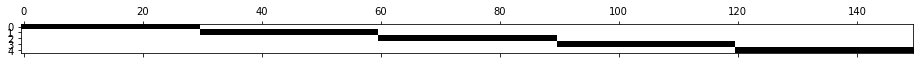

In [54]:
# Dibujas las mascaras
pl.matshow(masks,cmap='gray_r')

## Validación cruzada usando Scikit-Learn

Scikit-Learn provee una implementación muy eficiente para realizar **validación cruzada** usando `sklearn.model_selection` [(ver más)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). `sklearn.model_selection.cross_val_score` recibe un estimador y un conjunto de datos, luego 
hace el particionamiento y entrena un modelo sobre cada partición de validación.

In [55]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

El parámetro `cv` en `cross_val_score` controla el número de pliegues a usar.

In [56]:
# Carga de datos iris y definición del clasificador
X=iris.data
y=iris.target

classifier=LinearSVC(max_iter=10000)

In [57]:
classifier

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [58]:
# Validación cruzada para k=5
scores = cross_val_score(classifier, X, y, cv=5)

In [59]:
# Mostramos la accuracy por cada pliegue
# Mostramos promedio sobre los 5 pliegues
print("Accuracy por cada pliegue: {}".format(scores))
print("Promedio sobre los 5 pliegues: {}".format(np.mean(scores)))

Accuracy por cada pliegue: [1.         1.         0.93333333 0.9        1.        ]
Promedio sobre los 5 pliegues: 0.9666666666666668


`cross_val_score` realiza por defecto una partición estratificada usando `sklearn.model_selection.StratifiedKFold`. Esta estrategia consiste en hacer un particionamiento de tal forma que cada partición tenga la misma distribución de etiquetas $y$. En caso que no se quiera hacer una partición estratificada, se puede usar `sklearn.model_selection.KFold`.

`sklearn.model_selection.StratifiedKFold` genera de forma automática la partición estratificada, sin necesidad de hacer una permutación de los datos como lo hicimos anteriormente. A continuación revisamos los índices que genera `StratifiedKFold`:

In [60]:
# Realizar la estratificación y mostrar:
# Tamaño entrenamiento:
# Tamaño validación:

cv=StratifiedKFold(n_splits=5)

In [61]:
for train, val in cv.split(X,y):
  print("Datos de validación: {}".format(val))
  print("Tamaño de entrenamiento: {}".format(len(train)))
  print("Tamaño de validación: {}".format(len(val)))


Datos de validación: [  0   1   2   3   4   5   6   7   8   9  50  51  52  53  54  55  56  57
  58  59 100 101 102 103 104 105 106 107 108 109]
Tamaño de entrenamiento: 120
Tamaño de validación: 30
Datos de validación: [ 10  11  12  13  14  15  16  17  18  19  60  61  62  63  64  65  66  67
  68  69 110 111 112 113 114 115 116 117 118 119]
Tamaño de entrenamiento: 120
Tamaño de validación: 30
Datos de validación: [ 20  21  22  23  24  25  26  27  28  29  70  71  72  73  74  75  76  77
  78  79 120 121 122 123 124 125 126 127 128 129]
Tamaño de entrenamiento: 120
Tamaño de validación: 30
Datos de validación: [ 30  31  32  33  34  35  36  37  38  39  80  81  82  83  84  85  86  87
  88  89 130 131 132 133 134 135 136 137 138 139]
Tamaño de entrenamiento: 120
Tamaño de validación: 30
Datos de validación: [ 40  41  42  43  44  45  46  47  48  49  90  91  92  93  94  95  96  97
  98  99 140 141 142 143 144 145 146 147 148 149]
Tamaño de entrenamiento: 120
Tamaño de validación: 30


Usando una función definida previamente, vamos a validar la distribución de las etiquetas por clase.

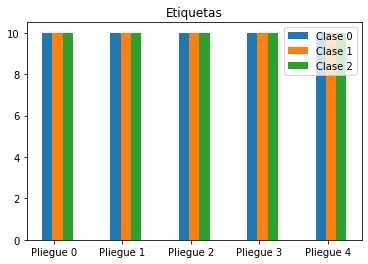

In [62]:
# Utilizar plot_labels con StratifiedKFold
cv=StratifiedKFold(n_splits=5)
ylabels=[]

for train, val in cv.split(X,y):
  ylabels.append(y[val])

plot_labels(5, 3, ylabels)

Por otro lado, usando `KFold` podemos obtener un particionamiento de tantos pliegues como se especifiquen. Sin embargo, se corre el riesgo de no generar particiones balanceadas, por lo tanto lo estimadores no van a tener el desempeño esperado. Por ejemplo en el **Pliegue 0** solo hay datos de la clase $0$.

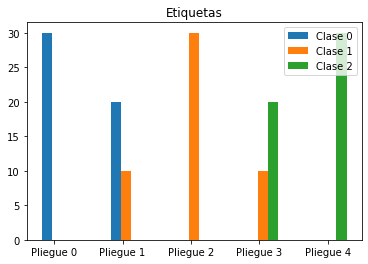

In [63]:
# Utilizar plot_labels con KFold
cv=KFold(n_splits=5)
ylabels=[]

for train, val in cv.split(X,y):
  ylabels.append(y[val])

plot_labels(5, 3, ylabels)

# Grid search

SVM usando RBF comúnmente requiere el ajuste de dos parámetros:
* `gamma`
* `C`

Ambos parámetros pueden ser explorados usando un retículo (grid) de parámetros y evaluando su desempeño usando validación cruzada de $k$ pliegues. A continuación, creamos una partición entrenamiento y prueba sobre el conjunto de datos IRIS.

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [65]:
# especificar estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=0)

Definimos los siguientes valores para $C=2i$ y $\gamma=i^2$, para $i=\{-5,7\}$.

In [86]:
grid=[i for i in range(-5,7,1)]
param_grid={'C':[2**i for i in grid], 'gamma':[2**(0.5*i) for i in grid]}

Valores de $C$:

In [87]:
param_grid['C']

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]

Valores de $\textit{gamma}$:

In [88]:
param_grid['gamma']

[0.1767766952966369,
 0.25,
 0.3535533905932738,
 0.5,
 0.7071067811865476,
 1.0,
 1.4142135623730951,
 2.0,
 2.8284271247461903,
 4.0,
 5.656854249492381,
 8.0]

`GridSearchCV` recibe dos elementos fundamentales:
* `estimator`: Modelo de Scikit-Learn. Puede ser `SVC(kernel='rbf')`.
* `param_grid`: Diccionario que contiene los parámetros que se van a explorar usando validación cruzada.

In [89]:
clf=GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid,n_jobs=-1,verbose=2)

In [90]:
clf

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64],
                         'gamma': [0.1767766952966369, 0.25, 0.3535533905932738,
                                   0.5, 0.7071067811865476, 1.0,
                                   1.4142135623730951, 2.0, 2.8284271247461903,
                                   4.0, 5.656854249492381, 8.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbo

In [91]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    1.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64],
                         'gamma': [0.1767766952966369, 0.25, 0.3535533905932738,
                                   0.5, 0.7071067811865476, 1.0,
                                   1.4142135623730951, 2.0, 2.8284271247461903,
                                   4.0, 5.656854249492381, 8.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbo

In [73]:
clf=GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid,verbose=2)

Los valores promedio de accuracy para cada combinación de hiperparámetros se pueden extraer usando `GridSearchCV.cv_results_`. Convertimos ese diccionario a un DataFrame de pandas.

In [92]:
import pandas as pd

cv_results=pd.DataFrame(clf.cv_results_)

In [95]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001174,0.000344,0.000577,0.000131,0.03125,0.176777,"{'C': 0.03125, 'gamma': 0.1767766952966369}",0.952381,0.952381,0.857143,0.952381,0.857143,0.914286,0.046657,117
1,0.001525,0.000442,0.000619,0.000112,0.03125,0.25,"{'C': 0.03125, 'gamma': 0.25}",0.952381,0.904762,0.857143,0.952381,0.857143,0.904762,0.042592,128
2,0.001431,0.000114,0.001501,0.001704,0.03125,0.353553,"{'C': 0.03125, 'gamma': 0.3535533905932738}",0.952381,0.904762,0.857143,0.952381,0.904762,0.914286,0.035635,87
3,0.001246,0.000192,0.004139,0.007087,0.03125,0.5,"{'C': 0.03125, 'gamma': 0.5}",0.952381,0.904762,0.857143,0.952381,0.904762,0.914286,0.035635,87
4,0.001326,0.000064,0.000611,0.000013,0.03125,0.707107,"{'C': 0.03125, 'gamma': 0.7071067811865476}",0.952381,0.904762,0.857143,0.952381,0.904762,0.914286,0.035635,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.001443,0.000372,0.000551,0.000016,64,2,"{'C': 64, 'gamma': 2.0}",0.952381,0.952381,0.809524,1.000000,0.904762,0.923810,0.064594,51
140,0.001372,0.000084,0.000582,0.000028,64,2.82843,"{'C': 64, 'gamma': 2.8284271247461903}",0.952381,0.952381,0.857143,1.000000,0.904762,0.933333,0.048562,28
141,0.001441,0.000030,0.000576,0.000014,64,4,"{'C': 64, 'gamma': 4.0}",0.952381,0.952381,0.857143,1.000000,0.857143,0.923810,0.057143,75
142,0.001561,0.000101,0.000581,0.000013,64,5.65685,"{'C': 64, 'gamma': 5.656854249492381}",0.952381,0.952381,0.857143,1.000000,0.857143,0.923810,0.057143,75


A continuación, observamos que el número de filas de ese DataFrame corresponde al número de configuraciones de hiperparámetros que se están explorando:

In [97]:
print(len(cv_results))
print(len(param_grid['C']))
print(len(param_grid['gamma']))
total=len(param_grid['C'])*len(param_grid['gamma'])
print(total)

144
12
12
144


Usando la columna `mean_test_score`, extraemos los accuracy promedio de la siguiente forma:

In [98]:
clf.cv_results_

{'mean_fit_time': array([0.00117393, 0.00152469, 0.00143118, 0.00124583, 0.00132618,
        0.00126648, 0.0019978 , 0.00129304, 0.00229607, 0.00161839,
        0.00185461, 0.00402513, 0.00130677, 0.00262771, 0.00263786,
        0.00124145, 0.00260224, 0.00160313, 0.00126595, 0.00249128,
        0.00295572, 0.00202193, 0.00355444, 0.00343165, 0.001057  ,
        0.00124025, 0.00382972, 0.00215721, 0.00109138, 0.00111189,
        0.00139756, 0.00593443, 0.00131292, 0.0013    , 0.0034915 ,
        0.00139003, 0.00285797, 0.0025598 , 0.00095906, 0.00099492,
        0.0010551 , 0.00386581, 0.0013195 , 0.00225892, 0.00127015,
        0.00134444, 0.00275164, 0.00519886, 0.00430655, 0.00125437,
        0.00273576, 0.00185847, 0.00245609, 0.00194669, 0.00299745,
        0.00255198, 0.00130706, 0.00226936, 0.00525393, 0.00448084,
        0.00215621, 0.00096464, 0.004351  , 0.0031404 , 0.00152149,
        0.00174985, 0.00110226, 0.00121093, 0.00383911, 0.00553422,
        0.00161366, 0.00418582,

In [101]:
scores=clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']),len(param_grid['gamma']))
scores

array([[0.91428571, 0.9047619 , 0.91428571, 0.91428571, 0.91428571,
        0.91428571, 0.92380952, 0.91428571, 0.9047619 , 0.91428571,
        0.85714286, 0.82857143],
       [0.91428571, 0.9047619 , 0.91428571, 0.91428571, 0.91428571,
        0.91428571, 0.92380952, 0.91428571, 0.9047619 , 0.91428571,
        0.85714286, 0.82857143],
       [0.91428571, 0.91428571, 0.91428571, 0.91428571, 0.91428571,
        0.91428571, 0.91428571, 0.91428571, 0.91428571, 0.91428571,
        0.85714286, 0.82857143],
       [0.91428571, 0.91428571, 0.91428571, 0.92380952, 0.91428571,
        0.92380952, 0.92380952, 0.92380952, 0.91428571, 0.93333333,
        0.8952381 , 0.84761905],
       [0.93333333, 0.92380952, 0.92380952, 0.92380952, 0.92380952,
        0.93333333, 0.94285714, 0.95238095, 0.95238095, 0.93333333,
        0.91428571, 0.8952381 ],
       [0.92380952, 0.92380952, 0.92380952, 0.94285714, 0.94285714,
        0.94285714, 0.94285714, 0.95238095, 0.94285714, 0.93333333,
        0.93333333,

A continuación, presentamos una forma de visualizar esta exploración sobre la malla de hiperparámetros

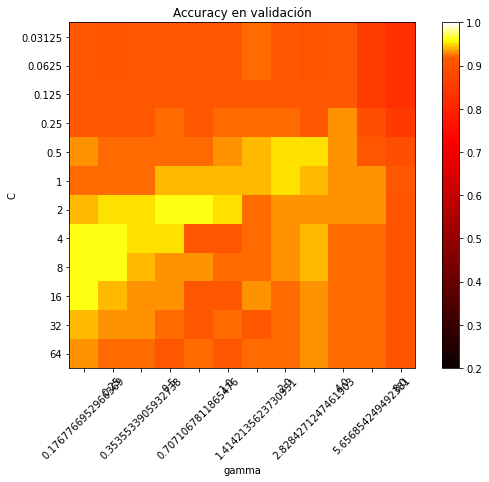

In [102]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92, vmax=1.))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy en validación')
plt.show()

Encontramos que existen tres modelos con el mejor desempeño usando validación cruzada:
* $C=2$ y $\gamma=0.5$
* $C=8$ y $\gamma=0.125$
* $C=4$ y $\gamma=0.5$

Para validar esta información, `GridSearchCV` nos ofrece una serie de métodos que nos permite consultar:
* La lista de resultados por elemento en la malla de parámetros (`cv_results_`)
* La configuración con el mejor desempeño (`best_params_`)
* El accuracy promediado sobre todos los pliegues de la mejor configuración (`best_score_`)

Para encontrar las mejores configuraciones, ordenamos la tabla de resultados de la siguiente manera:

In [105]:
cv_bestresults=cv_results[['param_C','param_gamma','mean_test_score']]

In [106]:
cv_bestresults.head()

,param_C,param_gamma,mean_test_score
0,0.03125,0.176777,0.914286
1,0.03125,0.25,0.904762
2,0.03125,0.353553,0.914286
3,0.03125,0.5,0.914286
4,0.03125,0.707107,0.914286


In [112]:
cv_bestresults.sort_values(by='mean_test_score', ascending=False)

,param_C,param_gamma,mean_test_score
85,4,0.25,0.961905
84,4,0.176777,0.961905
96,8,0.176777,0.961905
97,8,0.25,0.961905
108,16,0.176777,0.961905
...,...,...,...
34,0.125,5.65685,0.857143
47,0.25,8,0.847619
35,0.125,8,0.828571
23,0.0625,8,0.828571


Esta información también se puede consultar usando `.best_params_` y `.best_score_`.

In [110]:
clf.best_score_

0.9619047619047618

In [111]:
clf.best_params_

{'C': 2, 'gamma': 0.5}

Una vez se haya entrenado el modelo usando validación cruzada, `GridSearchCV` escoge automáticamente la mejor configuración y vuelve a entrenar un modelo sobre todo el conjunto de datos de entrenamiento. Por lo tanto se pueden hacer llamados a funciones como `predict()` y `score()`.

Para reportar sobre el conjunto de prueba basta con:

In [113]:
clf.score(X_test,y_test)

1.0